In [1]:
# 1MBA (myoglobin)
#seq = "SLSAAEADLAGKSWAPVFANKNANGLDFLVALFEKFPDSANFFADFKGKSVADIKASPKLRDVSSRIFTRLNEFVNNAANAGKMSAMLSQFAKEHVGFGVGSAQFENVRSMFPGFVASVAAPPAGADAAWTKLFGLIIDALKAAGA"

# 1MJC
# seq = "SGKMTGIVKWFNADKGFGFITPDDGSKDVFVHFSAIQNDGYKSLDEGQKVSFTIESGAKGPAAGNVTSL"

# Uniprot P37840 (IDP)
seq = "MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKEGVVHGVATVAEKTKEQVTNVGGAVVTGVTAVAQKTVEGAGSIAAATGFVKKDQLGKNEEGAPQEGILEDMPVDPDNEAYEMPSEEGYQDYEPEA"
# TODO: change this ss.a3m file name
with open("ss.a3m", "w") as f:
    f.write(f">test\n{seq}\n")

header = f"test|protein|ss.a3m"

with open("ss.fasta", "w") as f:
    f.write(f">{header}\n{seq}\n")

In [2]:
num_samples = 24
%run /projects/jlab/d.nori/FoldScaling/boltz/src/boltz/main.py predict ss.fasta --diffusion_samples {num_samples} --override --skip_pred --cache /projects/jlab/d.nori/FoldScaling/boltz

/home/d.nori/.conda/envs/foldscaling/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Checking input data.
Running predictions for 1 structure
Processing input data.


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]
/home/d.nori/.conda/envs/foldscaling/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /projects/jlab/d.nori/FoldScaling/boltz/src/boltz/ma ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Skipping prediction step as requested.


/home/d.nori/.conda/envs/foldscaling/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [3]:
processed = _boltz_inputs
data_module = BoltzInferenceDataModule(
    manifest=processed.manifest,
    target_dir=processed.targets_dir,
    msa_dir=processed.msa_dir,
    num_workers=1,
    constraints_dir=processed.constraints_dir,
)

batch = next(iter(data_module.predict_dataloader()))
batch = {k:v.cuda() if torch.is_tensor(v) else v for k,v in batch.items()}
model = _boltz_module.cuda()

In [4]:
trunk_out = model(
        batch,
        recycling_steps=model.predict_args["recycling_steps"],
        num_sampling_steps=model.predict_args["sampling_steps"],
        diffusion_samples=num_samples,
        return_final_reps=True,
        skip_diffusion=True)

# 64 samples per molecule, 100 diffusion steps

In [5]:
diff_outputs = model.structure_module.sample(
                    s_trunk=trunk_out['s_trunk'],
                    z_trunk=trunk_out['z_trunk'],
                    s_inputs=trunk_out['s_inputs'],
                    feats=trunk_out['feats'],
                    relative_position_encoding=trunk_out['relative_position_encoding'],
                    num_sampling_steps=model.predict_args["sampling_steps"],
                    atom_mask=trunk_out['feats']["atom_pad_mask"],
                    multiplicity=num_samples,
                    train_accumulate_token_repr=model.training,
                    steering_args={'fk_steering' : False, 'guidance_update': False},
                    custom_noise=None,
                    custom_potentials=[]
                )
# TODO: diff_outputs and trunk_out

In [6]:
model.confidence_module.use_s_diffusion=False
conf_out = model.confidence_module(
        s_inputs=trunk_out['s_trunk'],
        s=trunk_out['s_trunk'],
        z=trunk_out['z_trunk'],
        s_diffusion=None,
        x_pred=diff_outputs['sample_atom_coords'],
        feats=trunk_out['feats'],
        pred_distogram_logits=trunk_out["pdistogram"],
        multiplicity=model.predict_args["diffusion_samples"],
        run_sequentially=False
    )

(array([1., 2., 7., 5., 1., 2., 2., 2., 0., 2.]),
 array([0.34529102, 0.34841293, 0.35153484, 0.35465673, 0.35777864,
        0.36090055, 0.36402246, 0.36714438, 0.37026626, 0.37338817,
        0.37651008]),
 <BarContainer object of 10 artists>)

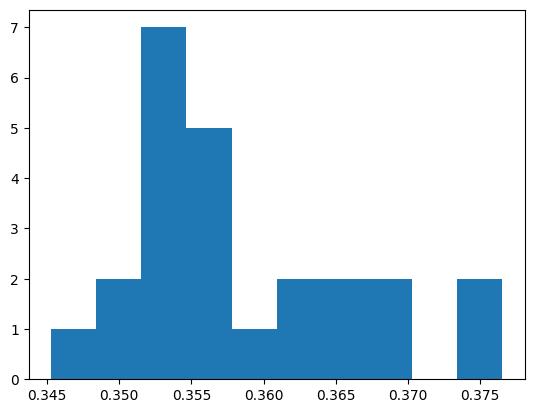

In [7]:
import matplotlib.pyplot as plt

conf_score = (4*conf_out['complex_plddt'] + conf_out['ptm']).cpu().numpy() /5
plt.hist(conf_score)

In [8]:
import torch
from boltz.model.potentials.potentials import Potential

def backbone_geometry_energy(coords, length_weights=None, angle_weights=None):
    """
    coords: tensor of shape (N, 3, 3)
        coords[:, 0] = N
        coords[:, 1] = CA
        coords[:, 2] = C
    returns: scalar tensor
    """
    # Defaults
    ideal_lengths = {
        'N-CA': 1.46,
        'CA-C': 1.53,
    }
    ideal_angles = {
        'N-CA-C': 111.0,  # degrees
    }

    length_weights = length_weights or {'N-CA': 100.0, 'CA-C': 100.0}
    angle_weights = angle_weights or {'N-CA-C': 10.0}

    total_energy = 0.0
    N = coords[:, 0]
    CA = coords[:, 1]
    C = coords[:, 2]

    # Bond lengths
    len_N_CA = torch.norm(N - CA, dim=1)
    len_CA_C = torch.norm(CA - C, dim=1)

    energy_N_CA = length_weights['N-CA'] * ((len_N_CA - ideal_lengths['N-CA'])**2).mean()
    energy_CA_C = length_weights['CA-C'] * ((len_CA_C - ideal_lengths['CA-C'])**2).mean()

    total_energy += energy_N_CA + energy_CA_C

    # Bond angles
    def angle(a, b, c):
        ba = a - b
        bc = c - b
        cosine = torch.sum(ba * bc, dim=1) / (torch.norm(ba, dim=1) * torch.norm(bc, dim=1))
        return angle_rad * 180.0 / torch.pi  # in degrees

    angle_N_CA_C = angle(N, CA, C)
    energy_angle = angle_weights['N-CA-C'] * ((angle_N_CA_C - ideal_angles['N-CA-C'])**2).mean()

    total_energy += energy_angle

    return total_energy

model.steering_args['num_particles']=4
model.steering_args['fk_lambda']=20
model.steering_args['fk_resampling_interval']=5
model.steering_args['guidance_update']=False
model.steering_args['max_fk_noise'] = 100
model.steering_args['potential_type'] = "vanilla"
model.steering_args['noise_coord_potential'] = False


"""
Class for FK guidance with backbone geometry as guiding potential
"""

class BackboneGeometryPotential(Potential):

    def compute_args(self, feats, params):
        return None, (), None

    def compute_variable(self, coords, index, compute_gradient=False):
        geo_e = backbone_geometry_energy(
            coords,
            length_weights=None,
            angle_weights=None
        )
        geo_e = geo_e.unsqueeze(-1)
        print(geo_e)

        if not compute_gradient:
            return -geo_e

        return -geo_e, torch.zeros_like(coords)

    def compute_function(self, value, compute_derivative=False):
        if not compute_derivative:
            return value
        return value, None


In [9]:
pot = BackboneGeometryPotential(parameters={
                'guidance_interval': 5,
                'guidance_weight': 1.0,
                'resampling_weight': 1.0,
            })

In [10]:
model.steering_args

{'fk_steering': True,
 'num_particles': 4,
 'fk_lambda': 20,
 'fk_resampling_interval': 5,
 'guidance_update': False,
 'num_gd_steps': 16,
 'max_fk_noise': 100,
 'potential_type': 'vanilla',
 'noise_coord_potential': False}

In [11]:
diff_outputs_guided = model.structure_module.sample(
                        s_trunk=trunk_out['s_trunk'],
                        z_trunk=trunk_out['z_trunk'],
                        s_inputs=trunk_out['s_inputs'],
                        feats=trunk_out['feats'],
                        relative_position_encoding=trunk_out['relative_position_encoding'],
                        num_sampling_steps=model.predict_args["sampling_steps"],
                        atom_mask=trunk_out['feats']["atom_pad_mask"],
                        multiplicity=num_samples,
                        train_accumulate_token_repr=model.training,
                        steering_args=model.steering_args,
                        custom_noise=None,
                        custom_potentials=[pot]
                    )

85.69275665283203
tensor([7154.3994], device='cuda:0')
tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.25

In [17]:
diff_outputs.keys()

dict_keys(['sample_atom_coords', 'diff_token_repr'])

In [16]:
diff_outputs_guided["sample_atom_coords"][0]

tensor([[-17.3740,  -4.9288,  -4.0433],
        [-16.1398,  -4.5841,  -4.7816],
        [-16.0803,  -3.1095,  -5.1517],
        ...,
        [  0.2252,   1.0541,  -1.8475],
        [ -2.6791,   1.9692,  -4.1812],
        [  0.7741,   1.9584,  -3.4529]], device='cuda:0')

In [12]:
conf_out_guided = model.confidence_module(
        s_inputs=trunk_out['s_trunk'],
        s=trunk_out['s_trunk'],
        z=trunk_out['z_trunk'],
        s_diffusion=None,
        x_pred=diff_outputs_guided['sample_atom_coords'],
        feats=trunk_out['feats'],
        pred_distogram_logits=trunk_out["pdistogram"],
        multiplicity=model.predict_args["diffusion_samples"],
        run_sequentially=False
    )

# TODO: run radius of gyration energy on all the coordinates and get rg for every sample

(array([6., 2., 6., 3., 2., 1., 0., 1., 0., 3.]),
 array([0.34383839, 0.34982294, 0.35580745, 0.361792  , 0.36777654,
        0.37376106, 0.3797456 , 0.38573015, 0.39171469, 0.39769921,
        0.40368375]),
 <BarContainer object of 10 artists>)

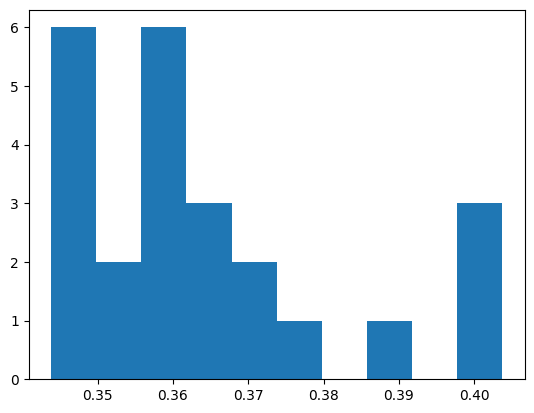

In [13]:
conf_score = (4*conf_out_guided['complex_plddt'] + conf_out_guided['ptm']).cpu().numpy() /5
plt.hist(conf_score)

# run samples guided and unguided and save all the outputs